In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.decomposition import PCA

In [19]:
df = pd.read_csv('./Video_games_esrb_rating.csv')
tag_columns = ['alcohol_reference', 'blood', 'suggestive_themes', 'violence']
X = df[tag_columns]
y = df['esrb_rating']

      alcohol_reference  blood  suggestive_themes  violence
0                     0      0                  0         0
1                     0      0                  0         0
2                     0      1                  1         0
3                     0      0                  0         0
4                     0      0                  1         0
...                 ...    ...                ...       ...
1890                  0      0                  0         0
1891                  0      0                  0         0
1892                  0      0                  0         0
1893                  0      1                  0         0
1894                  0      0                  0         0

[1895 rows x 4 columns]


In [22]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
X_pca_df = pd.DataFrame(X_pca, columns=['PC0', 'PC1'])

<Axes: xlabel='PC0', ylabel='PC1'>

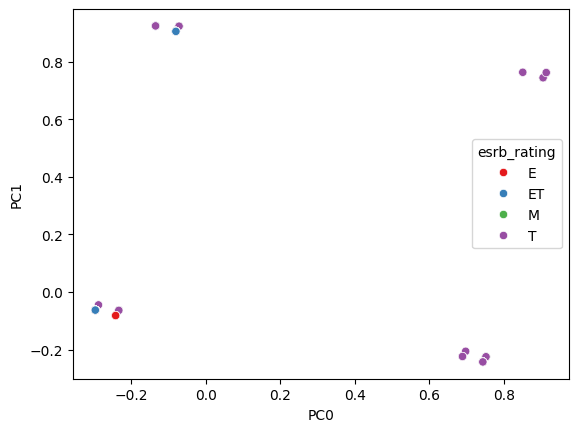

In [23]:
sns.set_palette('seismic')
sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue=y, palette='Set1')